---
title: Kaggle Tree EDA 
author: Daniil Solovjev
format: 
  html:
    code-fold: true
toc: true
jupyter: python3
---

Посмотрим на данные @table-head.

In [1]:
#| label: table-head
#| fig-cap: "Просмотр данных"
import os
import pandas as pd
from dotenv import load_dotenv


load_dotenv()
DATA_PATH = os.environ.get('KAGGLE_TREE_DATA')
df = pd.read_csv(DATA_PATH)
df.head()

Посмотрим по каким столбцам есть пропущенные значения @missing-values-in-columns.

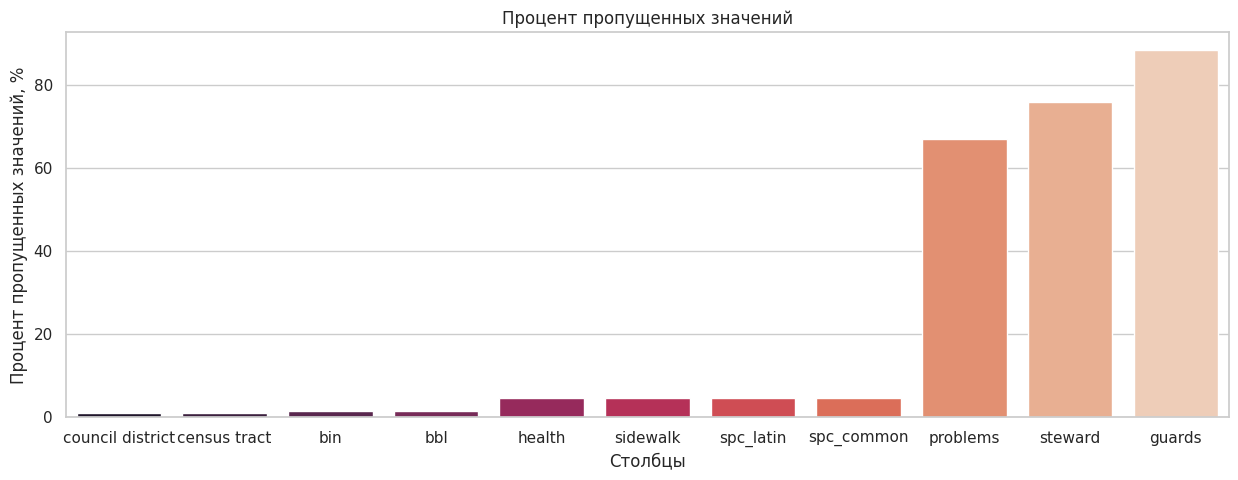

In [7]:
#| label: missing-values-in-columns
#| fig-cap: "Просмотр пропущенных значений в данных"
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")


nullable_df = df.isna().sum()
missing_data_percentage_df = nullable_df[nullable_df > 0] / len(df) * 100
missing_data_percentage_df = missing_data_percentage_df.sort_values()

f, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True)
x = missing_data_percentage_df.index
y = missing_data_percentage_df.values
sns.barplot(x=x, y=y, hue=x, palette="rocket", ax=ax, orient="y")
ax.set_ylabel("Процент пропущенных значений, %")
ax.set_xlabel("Столбцы")
ax.set_title("Процент пропущенных значений")
f.show()

Посмотрим на виды деревьев @tree-species.

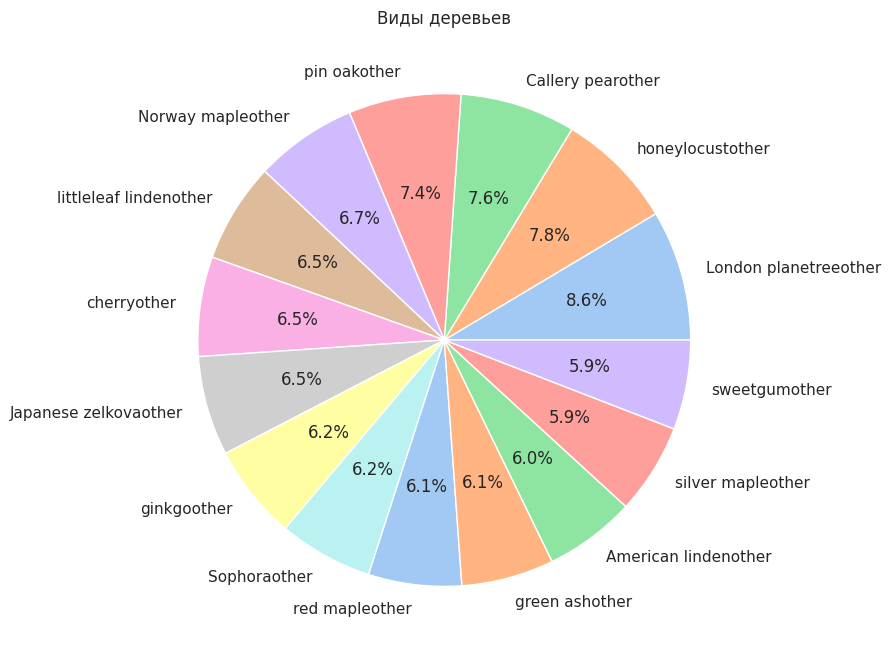

In [107]:
#| label: tree-species
#| fig-cap: "Диаграмма видов деревьев"
tree_species = df["spc_common"].value_counts()[:15]
labels = tree_species.index + ["other"]
values = tree_species.values + df["spc_common"].value_counts()[15:].values.sum()
colors = sns.color_palette('pastel')
f, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True)
ax.pie(values, labels=labels, colors=colors, autopct='%.1f%%')
ax.set_title("Виды деревьев")
f.show()

Проведем попарное сравнение некоторых признаков @pair-diagram.

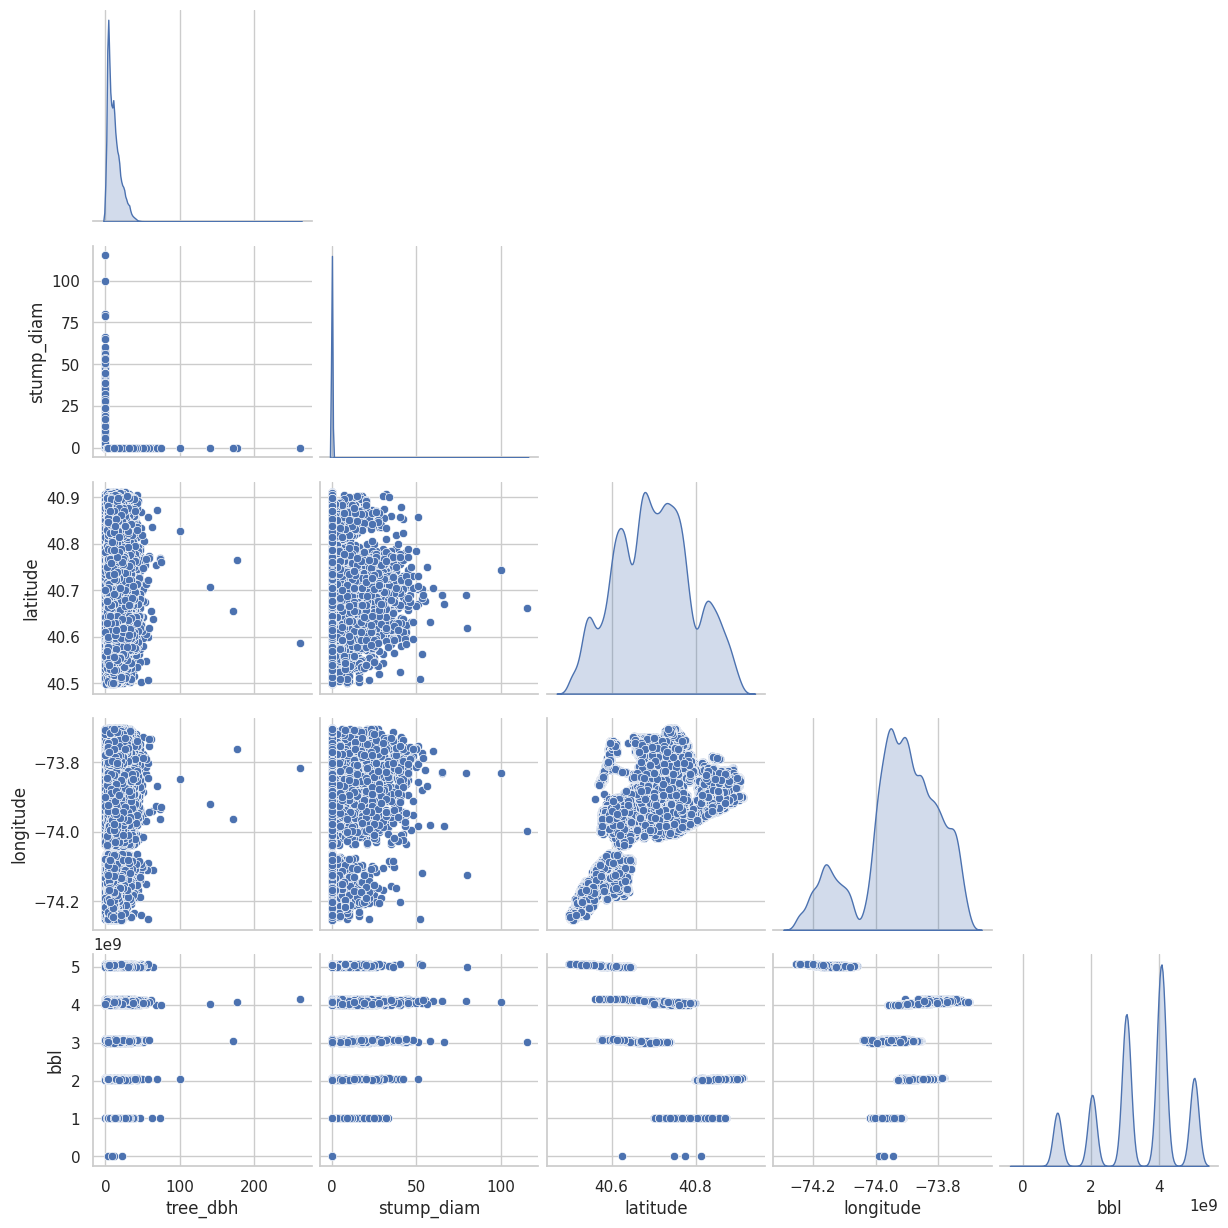

In [23]:
#| label: pair-diagram
#| fig-cap: "Диаграмма попарного сравнения"
PAIRPLOT_FEATURES = ["tree_dbh", "stump_diam", "latitude", "longitude"]
PAIRPLOT_N_ROWS = int(len(df) * 0.1)
pairplot_df = df[PAIRPLOT_FEATURES].sample(PAIRPLOT_N_ROWS)

pairplot = sns.pairplot(pairplot_df, diag_kind="kde", corner=True)

Посмотрим на тепловую карту корреляций вещественных признаков @corr-heatmap.

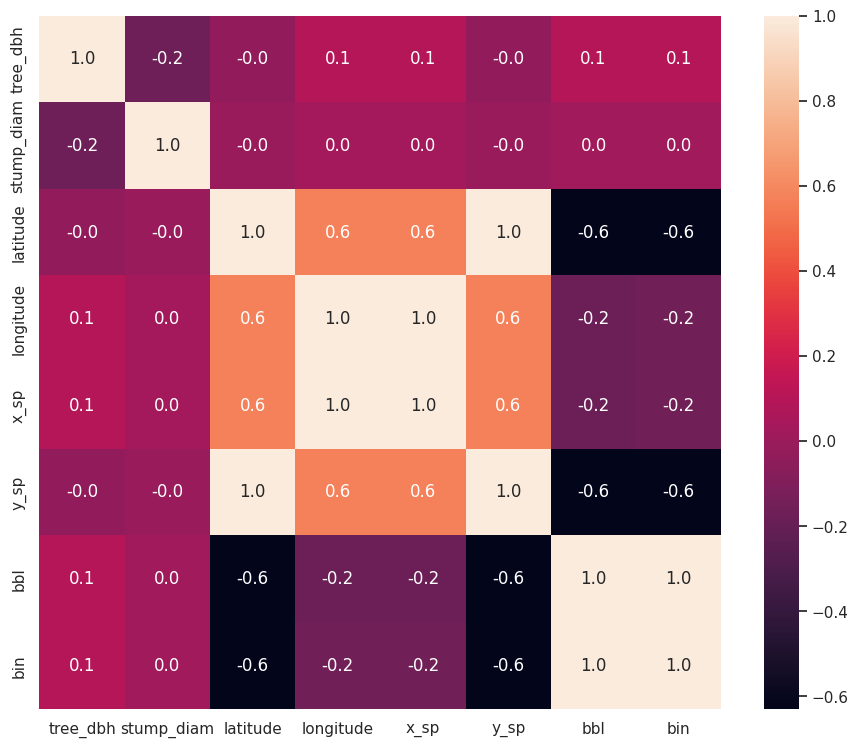

In [20]:
#| label: corr-heatmap
#| fig-cap: "Тепловая карта корреляции"
FLOAT_FEATURES = ["tree_dbh", "stump_diam", "latitude", "longitude", "x_sp", "y_sp", "bbl", "bin"]
corr_df = df[FLOAT_FEATURES].corr()
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_df, annot=True, fmt=".1f", ax=ax)
f.show()

Посмотрим распределение небольшой выборки деревьев на карте @map.

In [192]:
#| label: map
#| fig-cap: "Карта распределения деревьев"
import numpy as np
import folium
from folium.plugins import GroupedLayerControl
MAP_N_ROWS = 500


def colorize_by_health(health_status: str) -> str:
  if health_status == "Fair":
    return "green"
  elif health_status == "Good":
    return "orange"
  elif health_status == "Poor":
    return "red"
  else:
    return "gray"

center = df["latitude"].mean(), df["longitude"].mean()
map = folium.Map(location=center, zoom_start = 10)

species_groups = dict()
for spec in tree_species.index:
  species_groups[spec] = folium.FeatureGroup(name=spec.lower())
other_group = folium.FeatureGroup(name='other')

indexes = np.random.choice(len(df), MAP_N_ROWS)
for idx in indexes:
  row = df.iloc[idx]
  popup = f"tree_id={row.tree_id}"
  location = [row.latitude, row.longitude]
  icon = folium.Icon(color = colorize_by_health(row.health))
  group = species_groups.get(row.spc_common, other_group)
  folium.Marker(location = location, popup = popup, icon = icon, fill_opacity = 0.9).add_to(group)
  
groups = list(species_groups.values()) + [other_group]
for group in groups:
  map.add_child(group)

GroupedLayerControl(
    groups={'Виды деревьев': groups},
    exclusive_groups=False,
    collapsed=False,
)
map